In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# librería

In [ ]:
##### funciones de relaciones
def calcularRelaciones(matrizA, matrizB):
    # matriz de relaciones
    filas, columnas = matrizA.shape


    # calculo de kronecker (revisar optimizacion para calcular solo filas necesarias)
    kronecker = np.kron(matrizA, matrizB)
    filasKronecker, columnasKronecker = kronecker.shape

    # filtrado de filas y columnas
    filasIncluidas = np.linspace(0, filasKronecker - 1, filas, dtype = np.int16) # filas a incluir
    columnasBorradas = np.linspace(0, columnasKronecker - 1, columnas, dtype = np.int16) # columnas a borrar

    columnasRelaciones = columnas**2 - len(columnasBorradas)

    relaciones = np.zeros((filas, columnasRelaciones))
    relaciones = np.delete(kronecker, columnasBorradas, axis = 1)[filasIncluidas, :]

    return relaciones


def calcularRelacionesMovilesNoMoviles(matrizA, matrizB):
    kronecker = np.kron(matrizA, matrizB)
    filas, columnas = matrizB.shape
    filasKronecker, columnasKronecker = kronecker.shape

    # filtrado de filas y columnas
    filasIncluidas = np.linspace(0, filasKronecker - 1, filas, dtype = np.int16) # filas a incluir
    Relaciones = kronecker[filasIncluidas, :]
    return Relaciones

def promediosYCoefVariacion(df, relaciones):
    df_relaciones = df[relaciones]
    filas, columnas = df_relaciones.shape


    promedio = df_relaciones.mean()
    matrizPromedios = pd.DataFrame(np.ones((filas, columnas)), columns = relaciones)*promedio

    coefVariacion = df_relaciones.std()/np.abs(promedio)
    matrizCoefVariacion = pd.DataFrame(np.ones((filas, columnas)), columns = relaciones)*coefVariacion

    return matrizPromedios, matrizCoefVariacion

def calcularIndicesParcialesMayor(df, relaciones, promedios, coefVariaciones):
    df_relaciones = df[relaciones].reset_index(drop=True)
    comparacion = (df_relaciones.reset_index(drop=True) >= promedios)

    razonRelacionPromedio = (df_relaciones/promedios - 1).reset_index(drop=True)
    razonRelacionPromedio.fillna(0)

    indicesParciales = comparacion*razonRelacionPromedio/coefVariaciones
    indicesParciales.fillna(0)
    return indicesParciales


def calcularIndicesParcialesMenor(df, relaciones, promedios, coefVariaciones):
    df_relaciones = df[relaciones].reset_index(drop=True)
    comparacion = (df_relaciones.reset_index(drop=True) < promedios)

    razonRelacionPromedio = (1 - promedios/df_relaciones).reset_index(drop=True)
    razonRelacionPromedio.fillna(0)

    indicesParciales = comparacion*razonRelacionPromedio/coefVariaciones
    indicesParciales.fillna(0)
    return indicesParciales

def calcularFunciones(df, muestra, proporcion = 0.78, variable = "Pr"):
    dfPoblacion_altoRendimiento = extraerPoblacion(df, proporcion = proporcion, variable = variable)

    dfPoblacion_altoRendimiento2 = pd.concat([dfPoblacion_altoRendimiento.reset_index(drop=True), muestra.reset_index(drop=True)])

    relacionesMovilesNoMoviles = list(dfPoblacion_altoRendimiento.columns[14:])


    matrizPromedio, matrizCoefVariacion = promediosYCoefVariacion(dfPoblacion_altoRendimiento, relacionesMovilesNoMoviles)

    matrizPromedio = pd.concat([matrizPromedio, matrizPromedio.head(1)], axis = 0).reset_index(drop=True)
    matrizCoefVariacion =  pd.concat([matrizCoefVariacion, matrizCoefVariacion.head(1)], axis = 0).reset_index(drop=True)

    ################


    indicesParcialesMayor = calcularIndicesParcialesMayor(dfPoblacion_altoRendimiento2, relacionesMovilesNoMoviles, matrizPromedio, matrizCoefVariacion)

    indicesParcialesMenor = calcularIndicesParcialesMenor(dfPoblacion_altoRendimiento2, relacionesMovilesNoMoviles, matrizPromedio, matrizCoefVariacion)

    return indicesParcialesMayor + indicesParcialesMenor

##### utilidades
def nombresRelaciones(nutrientes):
    relaciones = []
    for i in nutrientes:
        for j in nutrientes:
            if i == j:
                pass
            else:
                relaciones = relaciones + ["{0}:{1}".format(i, j)]
    return relaciones

def nombresRelacionesMovilesNoMoviles(moviles, noMoviles):
    relaciones = []
    numRelaciones = len(moviles)*len(noMoviles)
    for i in moviles:
        for j in noMoviles:
            relaciones = relaciones + ["{0}:{1}".format(i, j)]
    return relaciones

def conteoRelaciones(nutrientes, relaciones):

    apariciones = len(nutrientes)*[0]
    cantidadRelacionesNutriente = dict(zip(nutrientes, apariciones))

    nutrientesRegex = [nutriente + ":" for nutriente in nutrientes]

    for nutriente in nutrientes:
        for relacion in relaciones:
            if relacion.startswith(nutriente):
                cantidadRelacionesNutriente[nutriente] = cantidadRelacionesNutriente[nutriente] + 1

    return cantidadRelacionesNutriente, nutrientesRegex

##### construccion de dfs

def cargarDf(ruta, delimitador = ","):
    df = pd.read_csv(ruta, delimiter = delimitador)
    nutrientes = list(df.columns)[3:]
    return df, nutrientes

def dataframeRelaciones(matrizA, matrizB, relaciones):
    dfRelaciones = pd.DataFrame(
                            calcularRelaciones(matrizA, matrizB),
                            columns = relaciones)
    return dfRelaciones, relaciones

def dfRelacionesDivision(df, nutrientes):
    matrixA = df[nutrientes]
    matrixB = 1/df[nutrientes]
    relaciones = nombresRelaciones(nutrientes)
    dfRelaciones, relaciones = dataframeRelaciones(matrixA, matrixB, relaciones)
    return dfRelaciones, relaciones

def dfRelacionesMovilesNoMoviles(df, nutrientes_moviles, nutrientes_no_moviles):
    df_uraba_moviles = df[nutrientes_moviles]
    df_uraba_noMoviles = df[nutrientes_no_moviles]

    relaciones = nombresRelacionesMovilesNoMoviles(nutrientes_moviles, nutrientes_no_moviles)

    arrayRelaciones = calcularRelacionesMovilesNoMoviles(df_uraba_moviles, df_uraba_noMoviles)

    dfRelaciones = pd.DataFrame(arrayRelaciones, columns = relaciones)
    return dfRelaciones, relaciones

def extraerPoblacion(df, proporcion = 0.78, variable = "Pr", poblacion = "alto rendimiento"):
    quantil = df[variable].quantile(proporcion)

    # alto o bajo rendimiento
    if poblacion == "alto rendimiento":
        mascara = calcularMascara(df[variable], quantil)
    else:
        mascara = calcularMascara(quantil, df[variable])


    dfPoblacion = df[mascara]
    return dfPoblacion


def calcularMascara(mayor, menor):
    mascara = mayor >= menor
    return mascara

##### orquestadores

def ingresoDeDatos(ruta, nutrientes_moviles, nutrientes_no_moviles, delimitador = ','):

    # carga df
    df, nutrientes = cargarDf(ruta, delimitador)

    # relaciones moviles
    dfRelaciones_moviles, relaciones_moviles = dfRelacionesDivision(df, nutrientes_moviles)

    # relaciones no moviles
    dfRelaciones_noMoviles, relaciones_noMoviles = dfRelacionesDivision(df, nutrientes_no_moviles)

    # relaciones moviles - no moviles
    dfRelaciones_moviles_noMoviles, relaciones = dfRelacionesMovilesNoMoviles(df, nutrientes_moviles, nutrientes_no_moviles)

    # construir bd !!!!!!
    df_relaciones = pd.concat([df, dfRelaciones_moviles, dfRelaciones_noMoviles, dfRelaciones_moviles_noMoviles], axis=1)

    return df_relaciones, nutrientes


def calcularIndices(df_relaciones, muestra):
    # preparacion
    nutrientes = list(df_relaciones.columns[3:14])

    df_indices = pd.DataFrame(columns = nutrientes)


    cantidadRelacionesNutriente, nutrientesRegex = conteoRelaciones(nutrientes, df_relaciones.columns[14:])

    funcion_altoRendimiento = calcularFunciones(df_relaciones, muestra)

    for i in range(len(nutrientes)):
        df_indices[nutrientes[i]] = funcion_altoRendimiento.filter(regex = nutrientesRegex[i]).sum(axis=1)/cantidadRelacionesNutriente[nutrientes[i]]

    return df_indices


In [ ]:
lista = ["N","P","K","Mg","S", "Ca","Fe","Mn","Cu","Zn","B"]
texto = ''
for i in lista:
    texto = texto + i + ', '

In [ ]:
texto

'N, P, K, Mg, S, Ca, Fe, Mn, Cu, Zn, B, '

## insumos

In [ ]:
# carga de archivos
carpeta_principal = "/content/drive/MyDrive/proyecto de grado/datosPrueba"
archivo_uraba = "Foliar_Pr_U.csv"
delimitador = ','

# columnas de interes
nutrientes_no_moviles = ["Ca","Fe","Mn","Cu","Zn","B"]
nutrientes_moviles = ["N","P","K","Mg","S"]

# filtros
proporcion = 0.78
variable = "Pr"

# ajustes
ruta_uraba = carpeta_principal + "/" + archivo_uraba
ruta_muestra = carpeta_principal + "/" + 'muestra_so_213.csv'

In [ ]:
relaciones_moviles = nombresRelaciones(nutrientes_moviles)
relaciones_noMoviles = nombresRelaciones(nutrientes_no_moviles) #30

## prueba librería, logica de ingreso de datos

In [ ]:
# base de datos
df_relaciones, nutrientes = ingresoDeDatos(ruta_uraba, nutrientes_moviles, nutrientes_no_moviles, delimitador = delimitador)

In [ ]:
df_muestra, nutrientes_muestra = ingresoDeDatos(ruta_muestra, nutrientes_moviles, nutrientes_no_moviles, delimitador = delimitador)

In [ ]:
df_muestra

,Mpio,Id,Pr,N,P,K,Ca,Mg,S,Fe,...,Mg:Mn,Mg:Cu,Mg:Zn,Mg:B,S:Ca,S:Fe,S:Mn,S:Cu,S:Zn,S:B
0,no aplica,213,31.65,3.26,0.19,3.12,0.68,0.41,0.13,126,...,317.75,3.69,9.02,15.99,0.0884,16.38,100.75,1.17,2.86,5.07


## prueba librería, logica de calculo de funciones

In [ ]:
df_relaciones

,Mpio,Id,Pr,N,P,S,Ca,Mg,K,Fe,...,Mg:Mn,Mg:Cu,Mg:Zn,Mg:B,S:Ca,S:Fe,S:Mn,S:Cu,S:Zn,S:B
0,Arboletes,112,7.28,2.68,0.24,0.10,0.99,0.39,4.16,102,...,73.71,2.73,7.41,13.65,0.0990,10.20,18.90,0.70,1.90,3.50
1,Arboletes,113,13.18,2.90,0.24,0.16,0.66,0.41,3.32,92,...,84.46,3.69,7.38,7.38,0.1056,14.72,32.96,1.44,2.88,2.88
2,Arboletes,114,9.49,2.62,0.23,0.18,0.70,0.42,3.73,82,...,60.06,3.78,7.98,15.96,0.1260,14.76,25.74,1.62,3.42,6.84
3,Mutatá,121,5.49,2.55,0.16,0.16,0.51,0.38,3.66,78,...,188.48,2.66,7.98,12.92,0.0816,12.48,79.36,1.12,3.36,5.44
4,Mutatá,122,5.08,2.22,0.20,0.13,0.62,0.38,3.39,89,...,155.80,3.04,6.84,8.74,0.0806,11.57,53.30,1.04,2.34,2.99
5,Mutatá,123,9.00,3.12,0.22,0.14,0.82,0.39,3.15,96,...,86.58,3.90,6.63,8.19,0.1148,13.44,31.08,1.40,2.38,2.94
6,Mutatá,124,8.06,3.37,0.17,0.15,0.86,0.42,2.98,81,...,108.36,3.78,6.72,9.66,0.1290,12.15,38.70,1.35,2.40,3.45
7,Necoclí,131,13.09,2.97,0.17,0.06,0.88,0.34,3.30,137,...,110.16,2.38,5.44,8.50,0.0528,8.22,19.44,0.42,0.96,1.50
8,Necoclí,132,7.75,3.31,0.19,0.12,0.87,0.36,3.69,94,...,154.08,2.88,6.12,14.04,0.1044,11.28,51.36,0.96,2.04,4.68
9,Necoclí,133,7.23,3.57,0.17,0.10,0.71,0.33,4.21,88,...,167.97,1.98,6.27,8.58,0.0710,8.80,50.90,0.60,1.90,2.60


In [ ]:
df_muestra

,Mpio,Id,Pr,N,P,K,Ca,Mg,S,Fe,...,Mg:Mn,Mg:Cu,Mg:Zn,Mg:B,S:Ca,S:Fe,S:Mn,S:Cu,S:Zn,S:B
0,no aplica,213,31.65,3.26,0.19,3.12,0.68,0.41,0.13,126,...,317.75,3.69,9.02,15.99,0.0884,16.38,100.75,1.17,2.86,5.07


In [ ]:
# calcular indices
################
df_indices = calcularIndices(df_relaciones, df_muestra)
df_indices_referencias = df_indices.iloc[:6]
df_indices_muestra = df_indices.iloc[6:]

aaaaa
         Mpio   Id     Pr     N     P     S    Ca    Mg     K   Fe  ...  \
1   Arboletes  113  13.18  2.90  0.24  0.16  0.66  0.41  3.32   92  ...   
7     Necoclí  131  13.09  2.97  0.17  0.06  0.88  0.34  3.30  137  ...   
12   San Juan  141  15.38  2.70  0.20  0.14  0.94  0.29  3.72   58  ...   
14   San Juan  143  15.73  3.27  0.19  0.07  1.02  0.26  3.56   81  ...   
19  San Pedro  154  11.70  3.72  0.19  0.13  0.79  0.43  3.11   86  ...   
22      Turbo  163  20.50  2.14  0.13  0.12  0.51  0.29  3.80   78  ...   

     Mg:Mn  Mg:Cu  Mg:Zn   Mg:B    S:Ca   S:Fe   S:Mn  S:Cu  S:Zn   S:B  
1    84.46   3.69   7.38   7.38  0.1056  14.72  32.96  1.44  2.88  2.88  
7   110.16   2.38   5.44   8.50  0.0528   8.22  19.44  0.42  0.96  1.50  
12   38.86   2.03   4.93   7.25  0.1316   8.12  18.76  0.98  2.38  3.50  
14  117.00   1.56   4.42   9.10  0.0714   5.67  31.50  0.42  1.19  2.45  
19   84.71   4.30   7.74  13.76  0.1027  11.18  25.61  1.30  2.34  4.16  
22   35.38   2.03   7.83

In [ ]:
df_indices

,N,P,S,Ca,Mg,K,Fe,Mn,Cu,Zn,B
0,-0.637909,0.696405,0.860270,-0.565429,0.322446,-0.675987,0.202513,-0.134161,0.652885,-0.281631,-1.027035
1,0.285185,-0.113659,-1.991357,-0.185673,0.428632,0.126071,1.099160,0.557875,-1.174315,-1.237296,-0.522921
2,-0.844797,-0.062688,0.402967,1.093273,-1.063504,-0.134325,-1.308405,-1.578049,0.010278,-0.061369,0.418380
3,0.727890,0.416623,-1.286763,0.123450,-0.820651,0.386430,-1.346629,1.548111,-2.121859,-0.970130,0.680812
4,0.853689,-0.144218,0.413036,-0.674899,0.859249,-0.591113,-0.480458,-0.784255,0.652375,-0.607300,0.775782
5,-1.741699,-2.164853,-0.114944,-1.085392,-0.980186,0.079201,0.325232,-1.355528,0.156667,1.790138,-1.906431
6,1.017147,0.691173,1.708570,-3.602702,1.639947,0.110134,-0.525339,3.691528,-1.363705,-1.095222,0.566583


In [ ]:
alto_rendimiento = df_relaciones['Pr'] > df_relaciones['Pr'].quantile(0.78)

In [ ]:
df_concentraciones_alto_rendimiento = df_relaciones[nutrientes][alto_rendimiento]
df_concentraciones_muestra = df_muestra[nutrientes]

In [ ]:
alto_rendimiento_media = df_concentraciones_alto_rendimiento.mean(axis = 0)
alto_rendimiento_std = df_concentraciones_alto_rendimiento.std(axis = 0)

In [ ]:
alto_rendimiento_media[nutrientes_moviles]

N     2.950000
P     0.186667
K     3.468333
Mg    0.336667
S     0.113333
dtype: float64

# Concentraciones

<ipython-input-35-29b119fddde0>:13: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i].stem(concentracion_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
<ipython-input-35-29b119fddde0>:14: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i].stem(concentracion_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of l

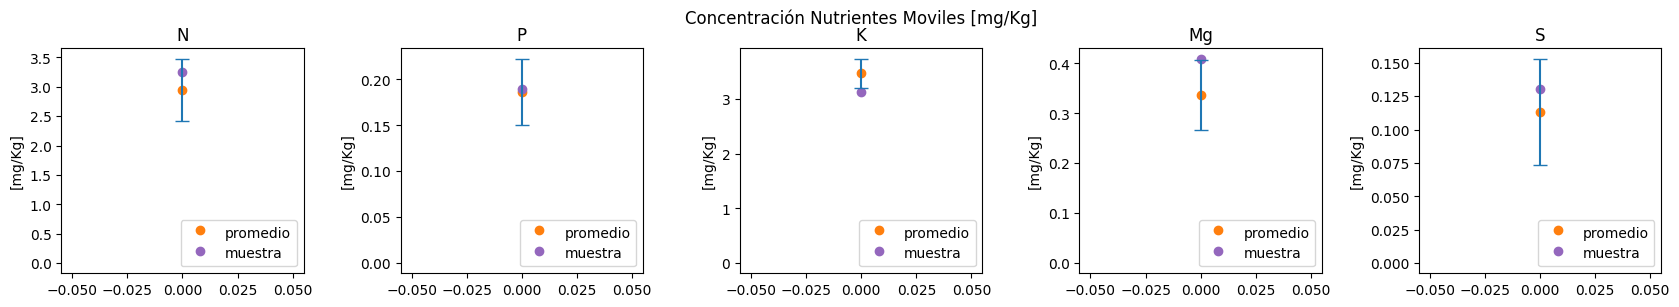

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize = (20, 3))
fig.suptitle("Concentración Nutrientes Moviles [mg/Kg]")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.6)

for i in range(len(nutrientes_moviles)):
    axs[i].set_title(nutrientes_moviles[i])
    axs[i].set_ylabel("[mg/Kg]")

    concentracion_media = [alto_rendimiento_media[nutrientes_moviles[i]]]
    concentracion_std = [alto_rendimiento_std[nutrientes_moviles[i]]]
    concentracion_muestra = [df_concentraciones_muestra[nutrientes_moviles[i]]]

    axs[i].stem(concentracion_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
    axs[i].stem(concentracion_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')

    axs[i].errorbar(np.arange(len(concentracion_media)), concentracion_media, yerr=concentracion_std, fmt='none', capsize=5)


    axs[i].legend(loc="lower right")



<ipython-input-36-632f60ccdcb3>:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i, j].stem(concentracion_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
<ipython-input-36-632f60ccdcb3>:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i, j].stem(concentracion_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')


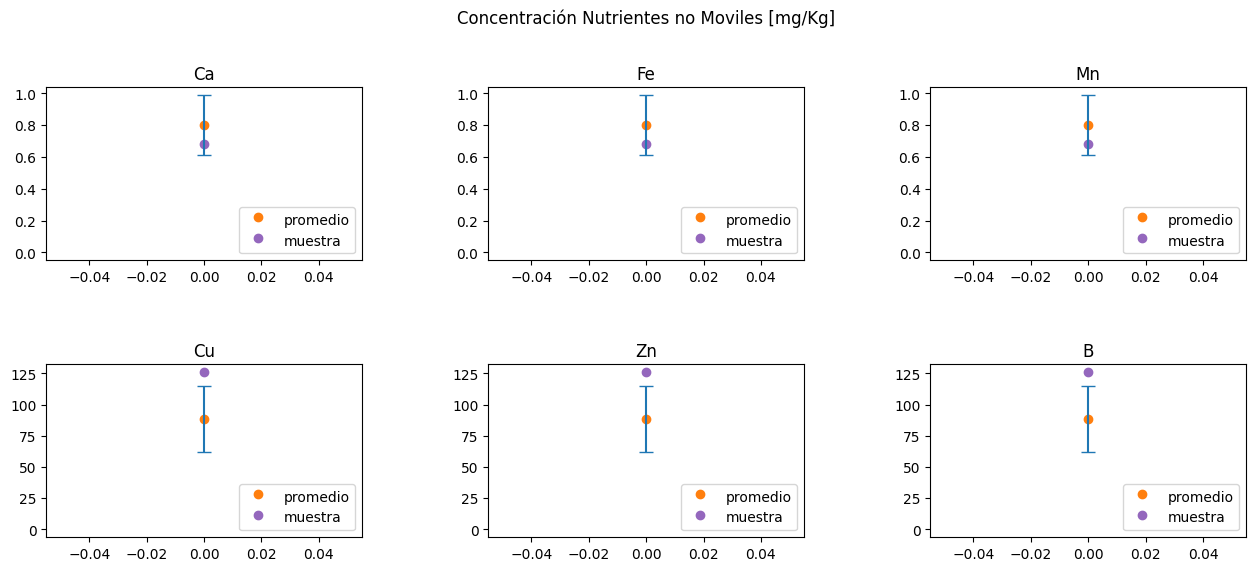

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (15, 6))
fig.suptitle("Concentración Nutrientes no Moviles [mg/Kg]")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.6)


contador = 0
for i in range(2):
    for j in range(3):
        axs[i, j].set_title(nutrientes_no_moviles[contador])
        contador = contador + 1

        concentracion_media = [alto_rendimiento_media[nutrientes_no_moviles[i]]]
        concentracion_std = [alto_rendimiento_std[nutrientes_no_moviles[i]]]
        concentracion_muestra = [df_concentraciones_muestra[nutrientes_no_moviles[i]]]

        axs[i, j].stem(concentracion_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
        axs[i, j].stem(concentracion_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')

        axs[i, j].errorbar(np.arange(len(concentracion_media)), concentracion_media, yerr=concentracion_std, fmt='none', capsize=5)

        axs[i, j].legend(loc="lower right")


# indices de dris

In [ ]:
df_indices_referencias_media = df_indices_referencias.mean(axis = 0)
df_indices_referencias_std = df_indices_referencias.std(axis = 0)

df_indices_muestra = df_indices.iloc[6:]

<ipython-input-38-a4b4cc3d8075>:13: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i].stem(indices_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
<ipython-input-38-a4b4cc3d8075>:14: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i].stem(indices_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tupl

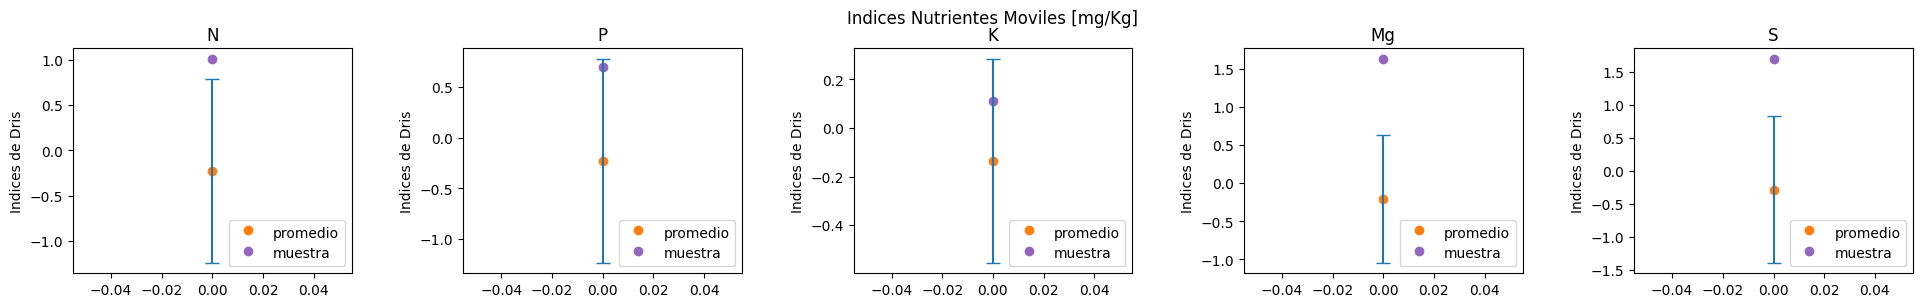

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize = (23, 3))
fig.suptitle("Indices Nutrientes Moviles [mg/Kg]")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.6)

for i in range(len(nutrientes_moviles)):
    axs[i].set_title(nutrientes_moviles[i])
    axs[i].set_ylabel("Indices de Dris")

    indices_media = [df_indices_referencias_media[nutrientes_moviles[i]]]
    indices_std = [df_indices_referencias_std[nutrientes_moviles[i]]]
    indices_muestra = [df_indices_muestra[nutrientes_moviles[i]]]

    axs[i].stem(indices_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
    axs[i].stem(indices_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')

    axs[i].errorbar(np.arange(len(indices_media)), indices_media, yerr=indices_std, fmt='none', capsize=5)


    axs[i].legend(loc="lower right")

<ipython-input-40-e06d6774bef5>:18: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i, j].stem(indices_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
<ipython-input-40-e06d6774bef5>:19: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axs[i, j].stem(indices_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

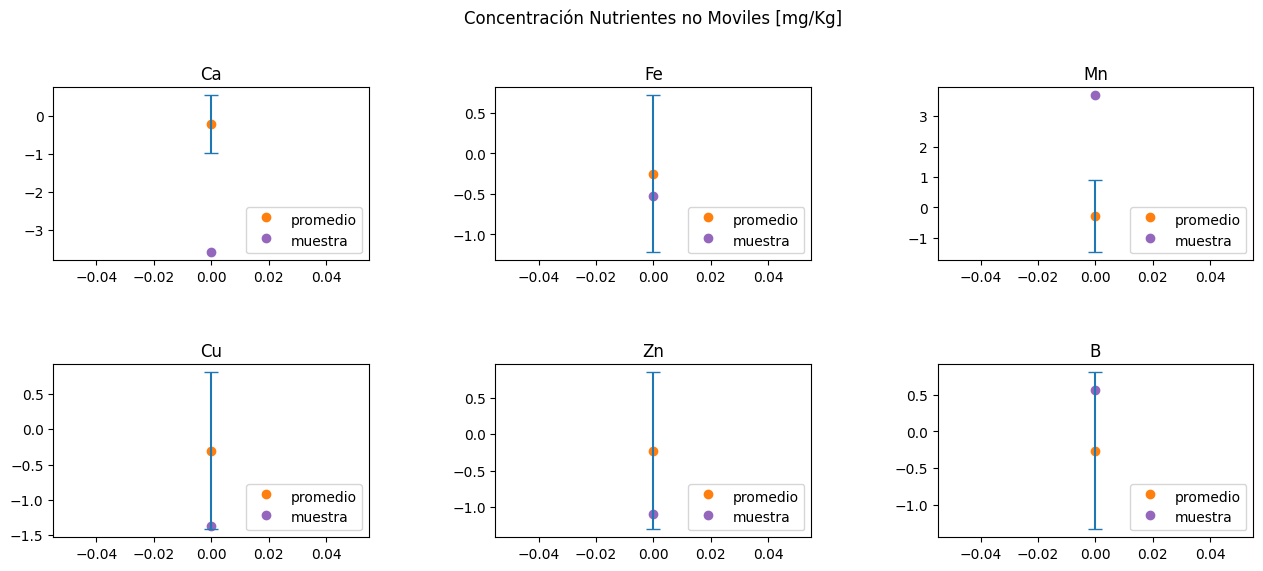

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (15, 6))
fig.suptitle("Concentración Nutrientes no Moviles [mg/Kg]")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.6)


contador = 0
for i in range(2):
    for j in range(3):
        axs[i, j].set_title(nutrientes_no_moviles[contador])


        indices_media = [df_indices_referencias_media[nutrientes_no_moviles[contador]]]
        indices_std = [df_indices_referencias_std[nutrientes_no_moviles[contador]]]
        indices_muestra = [df_indices_muestra[nutrientes_no_moviles[contador]]]

        contador = contador + 1

        axs[i, j].stem(indices_media, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='promedio')
        axs[i, j].stem(indices_muestra, linefmt=' ', markerfmt='o', basefmt=' ', use_line_collection=False, label='muestra')

        axs[i, j].errorbar(np.arange(len(indices_media)), indices_media, yerr=indices_std, fmt='none', capsize=5)

        axs[i, j].legend(loc="lower right")

In [ ]:
df_indices_referencias_media

N    -0.399694
P    -0.343905
S    -0.479787
Ca    0.039879
Mg   -0.428606
K    -0.167033
Fe   -0.265580
Mn   -0.753210
Cu   -0.193457
Zn   -0.136447
B    -0.375293
dtype: float64